# Persoalan
Unduhlah salah satu data di situs SEKI https://www.bi.go.id/id/statistik/ekonomi-
keuangan/seki/default.aspx , Lakukan  prediktif analitik, time series forecasting untuk 
menganalisis ada tidaknya tren, siklus atau seasonal. Berikan penjelasan hasil perhitungan 
dan carilah perhitungan performanya.

## Packages

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA, sarimax

## Input Data

In [101]:
df = pd.read_excel('../dataset/TABEL7_1_revisi.xlsx', sheet_name='Sheet3')

In [102]:
df['Quarter'] = pd.to_datetime(df['Quarter'], format='%B %Y')
df.set_index('Quarter', inplace=True)


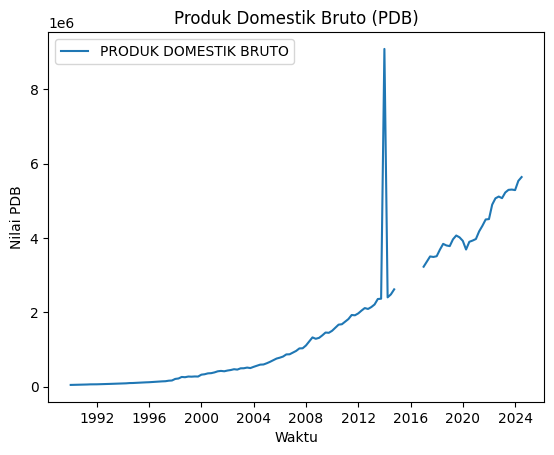

In [103]:
plt.plot(df.index, df['PRODUK DOMESTIK BRUTO'], label='PRODUK DOMESTIK BRUTO')
plt.title('Produk Domestik Bruto (PDB)')
plt.xlabel('Waktu')
plt.ylabel('Nilai PDB')
plt.legend()
plt.show()

## Cleaning Data

In [104]:
model = ARIMA(df['PRODUK DOMESTIK BRUTO'], order=(1, 1, 1))
model_fit = model.fit()
df['PRODUK DOMESTIK BRUTO'] = df['PRODUK DOMESTIK BRUTO'].fillna(model_fit.predict())

# df['PRODUK DOMESTIK BRUTO'] = df['PRODUK DOMESTIK BRUTO'].interpolate(method='linear') 

/home/budi-setiawan/Repositories/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/budi-setiawan/Repositories/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/budi-setiawan/Repositories/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


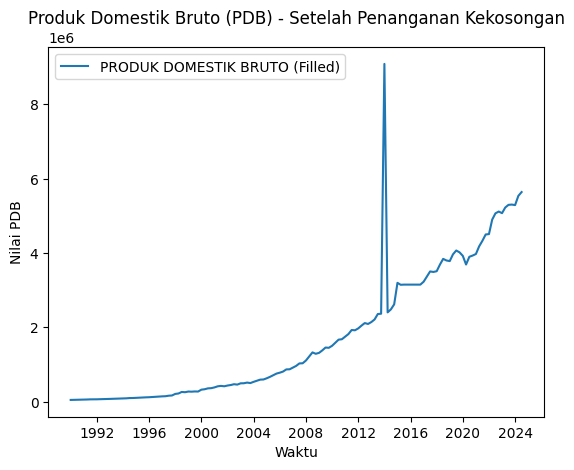

In [105]:
plt.plot(df.index, df['PRODUK DOMESTIK BRUTO'], label='PRODUK DOMESTIK BRUTO (Filled)')
plt.title('Produk Domestik Bruto (PDB) - Setelah Penanganan Kekosongan')
plt.xlabel('Waktu')
plt.ylabel('Nilai PDB')
plt.legend()
plt.show()

In [106]:
print(df['PRODUK DOMESTIK BRUTO'].isnull().sum())  # Jumlah NaN
print(df['PRODUK DOMESTIK BRUTO'].describe())

0
count    1.390000e+02
mean     1.737813e+06
std      1.790706e+06
min      4.995840e+04
25%      2.606848e+05
50%      9.638625e+05
75%      3.149924e+06
max      9.083972e+06
Name: PRODUK DOMESTIK BRUTO, dtype: float64


In [107]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['PRODUK DOMESTIK BRUTO'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("Data tidak stasioner. Lakukan differencing.")

ADF Statistic: 1.292812665061388
p-value: 0.9965683888301475
Data tidak stasioner. Lakukan differencing.


In [108]:
# df['PRODUK DOMESTIK BRUTO_DIFF'] = df['PRODUK DOMESTIK BRUTO'].diff().dropna()
df['PRODUK DOMESTIK BRUTO'] = df['PRODUK DOMESTIK BRUTO'].diff().dropna()

## Prediction

/home/budi-setiawan/Repositories/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/budi-setiawan/Repositories/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/budi-setiawan/Repositories/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_184552/1326022446.py:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=3), periods=forecast_steps, freq='Q')


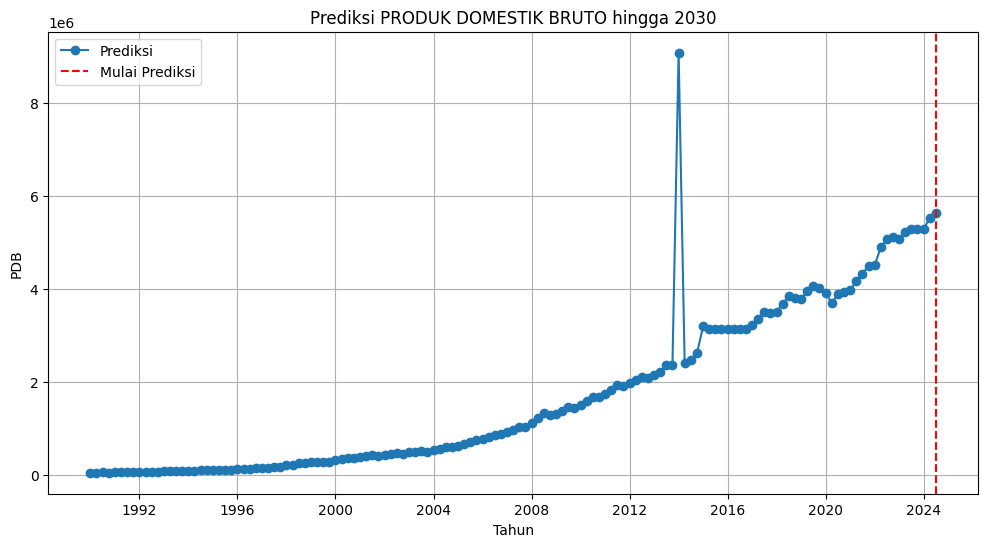

            PRODUK DOMESTIK BRUTO
2024-12-31                    NaN
2025-03-31                    NaN
2025-06-30                    NaN
2025-09-30                    NaN
2025-12-31                    NaN
2026-03-31                    NaN
2026-06-30                    NaN
2026-09-30                    NaN
2026-12-31                    NaN
2027-03-31                    NaN
2027-06-30                    NaN
2027-09-30                    NaN
2027-12-31                    NaN
2028-03-31                    NaN
2028-06-30                    NaN
2028-09-30                    NaN
2028-12-31                    NaN
2029-03-31                    NaN
2029-06-30                    NaN
2029-09-30                    NaN
2029-12-31                    NaN
2030-03-31                    NaN
2030-06-30                    NaN
2030-09-30                    NaN


In [99]:
# Membuat model ARIMA
model = ARIMA(df['PRODUK DOMESTIK BRUTO'], order=(1, 1, 1))  # Sesuaikan order berdasarkan analisis ACF/PACF
model_fit = model.fit()

# Prediksi hingga 2030 (24 kuartal dari 2024 hingga 2030)
forecast_steps = (2030 - 2024) * 4
forecast = model_fit.forecast(steps=forecast_steps)

# Membuat DataFrame untuk prediksi
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=3), periods=forecast_steps, freq='Q')
forecast_df = pd.DataFrame({'PRODUK DOMESTIK BRUTO': forecast}, index=future_dates)

# Gabungkan data historis dengan prediksi
result = pd.concat([df, forecast_df])

# Visualisasi hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(result.index, result['PRODUK DOMESTIK BRUTO'], label='Prediksi', marker='o')
plt.axvline(x=df.index[-1], color='red', linestyle='--', label='Mulai Prediksi')
plt.title('Prediksi PRODUK DOMESTIK BRUTO hingga 2030')
plt.xlabel('Tahun')
plt.ylabel('PDB')
plt.legend()
plt.grid()
plt.show()

# Menampilkan hasil prediksi
print(forecast_df)


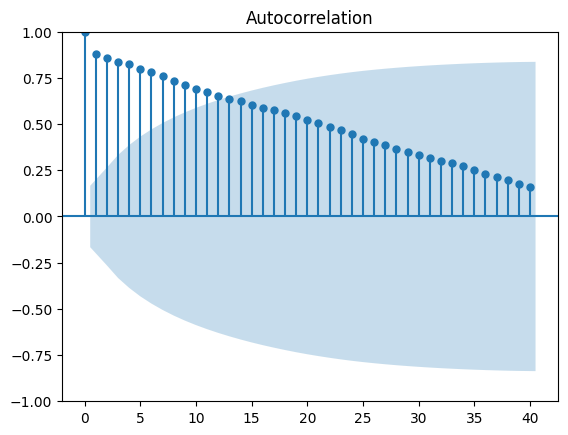

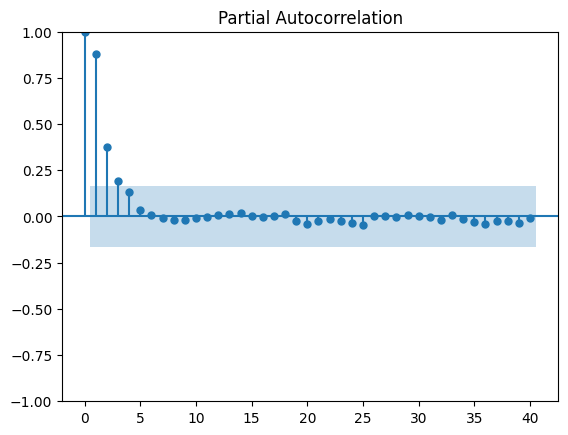

In [97]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['PRODUK DOMESTIK BRUTO'].dropna(), lags=40)
plot_pacf(df['PRODUK DOMESTIK BRUTO'].dropna(), lags=40)
plt.show()

In [98]:
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:             PRODUK DOMESTIK BRUTO   No. Observations:                  139
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood               -2001.297
Date:                           Fri, 13 Dec 2024   AIC                           4012.594
Time:                                   07:04:19   BIC                           4027.083
Sample:                               01-01-1990   HQIC                          4018.482
                                    - 07-01-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0500      0.223     -0.225      0.822      -0.487       0.386
ma.L1         -0.8391      0.130     -6.467